In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

2023-02-01 23:14:03.913402: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
labels.shape

(503, 512, 512, 1)

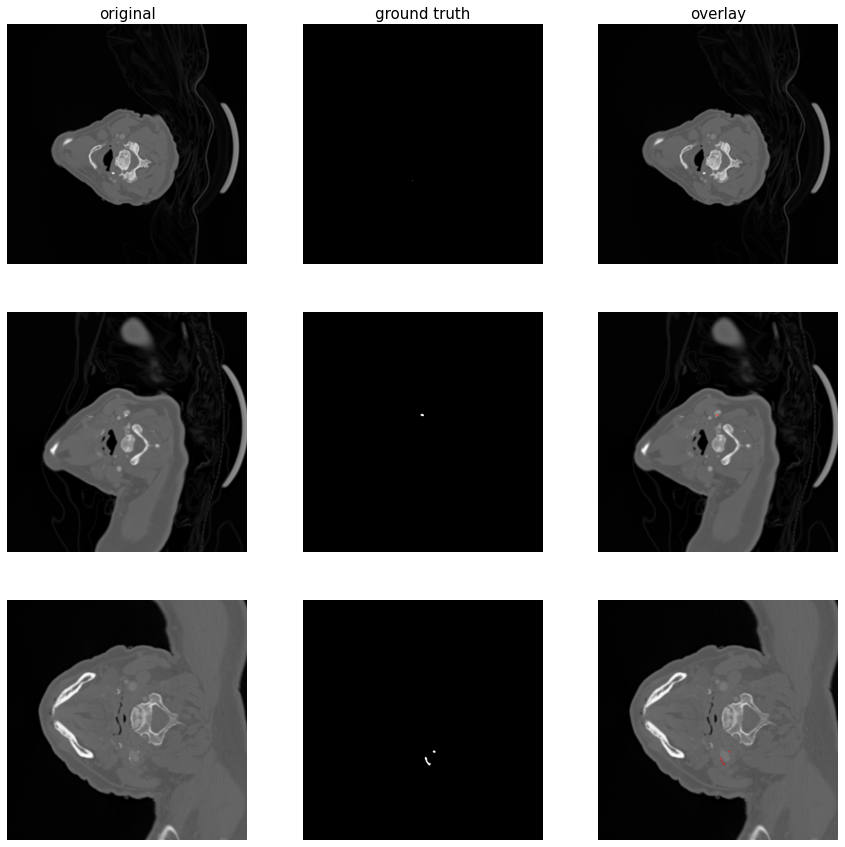

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [13]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [14]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

(2, 512, 512, 1) (2, 512, 512, 1)


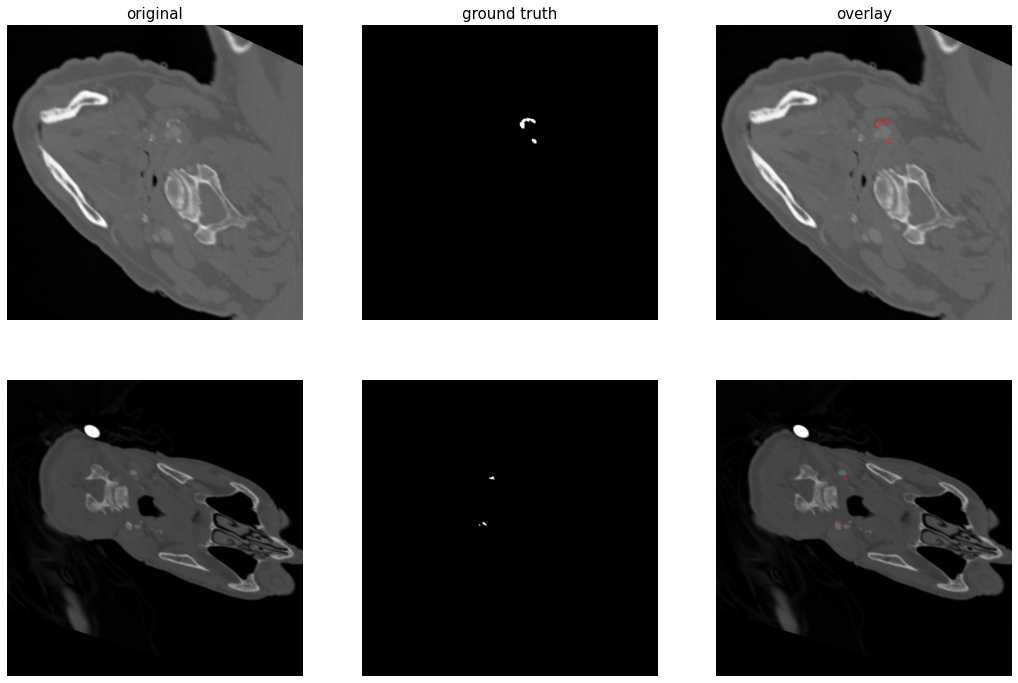

In [15]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [16]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-01 23:14:51.521114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-01 23:14:51.615613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-01 23:14:51.615663: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-01 23:14:51.615715: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 23:14:51.615744: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 23:14:51.622759: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2023-02-01 23:14:51.643279: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 23:14:51.647562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:87:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-01 23:14:51.655755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2023-02-01 23:14:51.656107: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-01 23:14:52.483371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecuto

In [17]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [18]:
from tensorflow.keras import optimizers
#from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses
#from keras_unet.losses import jaccard_distance

In [19]:
model.compile(loss='binary_crossentropy',
              #loss=jaccard_distance,
              optimizer=optimizers.Adam(lr=1e-3),
              #optimizer = 'Adam',
              metrics=[iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [20]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=200,
                    validation_data=(X_val, y_val))

2023-02-01 23:15:08.172142: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-01 23:15:08.193167: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/200


2023-02-01 23:15:33.111614: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 23:15:34.312000: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 23:15:34.312333: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-01 23:15:34.450597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-01 23:15:34.638616: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-01 23:15:35.401412: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-01 23:15:35.401434: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-01 23:15:35.40180

19/19 [==============================] - 46s 1s/step - loss: 0.1072 - iou: 5.9317e-04 - iou_thresholded: 8.3790e-04 - val_loss: 0.0051 - val_iou: 0.0011 - val_iou_thresholded: 0.0013
Epoch 2/200
19/19 [==============================] - 14s 745ms/step - loss: 0.0094 - iou: 9.2218e-04 - iou_thresholded: 0.0010 - val_loss: 0.0120 - val_iou: 0.0013 - val_iou_thresholded: 0.0013
Epoch 3/200
19/19 [==============================] - 14s 746ms/step - loss: 0.0064 - iou: 8.6243e-04 - iou_thresholded: 0.0011 - val_loss: 0.0033 - val_iou: 0.0013 - val_iou_thresholded: 0.0013
Epoch 4/200
19/19 [==============================] - 14s 734ms/step - loss: 0.0073 - iou: 0.0010 - iou_thresholded: 9.9644e-04 - val_loss: 0.0080 - val_iou: 0.0013 - val_iou_thresholded: 0.0013
Epoch 5/200
19/19 [==============================] - 14s 743ms/step - loss: 0.0066 - iou: 6.6936e-04 - iou_thresholded: 0.0010 - val_loss: 0.0051 - val_iou: 9.9233e-04 - val_iou_thresholded: 0.0013
Epoch 6/200
19/19 [==================

19/19 [==============================] - 14s 751ms/step - loss: 5.1755e-04 - iou: 0.3015 - iou_thresholded: 0.3827 - val_loss: 6.7926e-04 - val_iou: 0.2430 - val_iou_thresholded: 0.2899
Epoch 44/200
19/19 [==============================] - 14s 731ms/step - loss: 4.4240e-04 - iou: 0.3366 - iou_thresholded: 0.4257 - val_loss: 6.5589e-04 - val_iou: 0.2690 - val_iou_thresholded: 0.3847
Epoch 45/200
19/19 [==============================] - 14s 740ms/step - loss: 4.3419e-04 - iou: 0.3461 - iou_thresholded: 0.4310 - val_loss: 6.5382e-04 - val_iou: 0.2663 - val_iou_thresholded: 0.3562
Epoch 46/200
19/19 [==============================] - 14s 746ms/step - loss: 4.5078e-04 - iou: 0.3334 - iou_thresholded: 0.4252 - val_loss: 6.5371e-04 - val_iou: 0.2694 - val_iou_thresholded: 0.3415
Epoch 47/200
19/19 [==============================] - 14s 735ms/step - loss: 4.0278e-04 - iou: 0.3555 - iou_thresholded: 0.4540 - val_loss: 6.2533e-04 - val_iou: 0.2804 - val_iou_thresholded: 0.3372
Epoch 48/200
19/19

19/19 [==============================] - 14s 741ms/step - loss: 1.3009e-04 - iou: 0.6825 - iou_thresholded: 0.8030 - val_loss: 6.8347e-04 - val_iou: 0.4187 - val_iou_thresholded: 0.4566
Epoch 85/200
19/19 [==============================] - 14s 744ms/step - loss: 1.2383e-04 - iou: 0.6919 - iou_thresholded: 0.8100 - val_loss: 6.7713e-04 - val_iou: 0.4230 - val_iou_thresholded: 0.4586
Epoch 86/200
19/19 [==============================] - 14s 743ms/step - loss: 1.1558e-04 - iou: 0.7063 - iou_thresholded: 0.8278 - val_loss: 6.6895e-04 - val_iou: 0.4347 - val_iou_thresholded: 0.4713
Epoch 87/200
19/19 [==============================] - 14s 730ms/step - loss: 1.1246e-04 - iou: 0.7137 - iou_thresholded: 0.8317 - val_loss: 7.0907e-04 - val_iou: 0.4161 - val_iou_thresholded: 0.4419
Epoch 88/200
19/19 [==============================] - 14s 742ms/step - loss: 1.1487e-04 - iou: 0.7143 - iou_thresholded: 0.8275 - val_loss: 6.7691e-04 - val_iou: 0.4388 - val_iou_thresholded: 0.4711
Epoch 89/200
19/19

19/19 [==============================] - 14s 734ms/step - loss: 4.2402e-05 - iou: 0.8668 - iou_thresholded: 0.9577 - val_loss: 8.4709e-04 - val_iou: 0.4673 - val_iou_thresholded: 0.4875
Epoch 126/200
19/19 [==============================] - 14s 749ms/step - loss: 4.0541e-05 - iou: 0.8729 - iou_thresholded: 0.9616 - val_loss: 8.6925e-04 - val_iou: 0.4648 - val_iou_thresholded: 0.4837
Epoch 127/200
19/19 [==============================] - 14s 738ms/step - loss: 3.9477e-05 - iou: 0.8740 - iou_thresholded: 0.9628 - val_loss: 8.7607e-04 - val_iou: 0.4631 - val_iou_thresholded: 0.4830
Epoch 128/200
19/19 [==============================] - 14s 733ms/step - loss: 3.7871e-05 - iou: 0.8781 - iou_thresholded: 0.9646 - val_loss: 8.7672e-04 - val_iou: 0.4627 - val_iou_thresholded: 0.4820
Epoch 129/200
19/19 [==============================] - 14s 751ms/step - loss: 3.8872e-05 - iou: 0.8747 - iou_thresholded: 0.9630 - val_loss: 8.8601e-04 - val_iou: 0.4622 - val_iou_thresholded: 0.4799
Epoch 130/200


19/19 [==============================] - 14s 746ms/step - loss: 1.4555e-05 - iou: 0.9445 - iou_thresholded: 0.9991 - val_loss: 9.7460e-04 - val_iou: 0.4671 - val_iou_thresholded: 0.4790
Epoch 167/200
19/19 [==============================] - 14s 744ms/step - loss: 1.4140e-05 - iou: 0.9459 - iou_thresholded: 0.9990 - val_loss: 9.8472e-04 - val_iou: 0.4665 - val_iou_thresholded: 0.4774
Epoch 168/200
19/19 [==============================] - 14s 735ms/step - loss: 1.3823e-05 - iou: 0.9470 - iou_thresholded: 0.9989 - val_loss: 9.9738e-04 - val_iou: 0.4653 - val_iou_thresholded: 0.4748
Epoch 169/200
19/19 [==============================] - 14s 737ms/step - loss: 1.3387e-05 - iou: 0.9488 - iou_thresholded: 0.9990 - val_loss: 0.0010 - val_iou: 0.4643 - val_iou_thresholded: 0.4735
Epoch 170/200
19/19 [==============================] - 14s 732ms/step - loss: 1.3215e-05 - iou: 0.9498 - iou_thresholded: 0.9986 - val_loss: 0.0010 - val_iou: 0.4653 - val_iou_thresholded: 0.4750
Epoch 171/200
19/19 [=

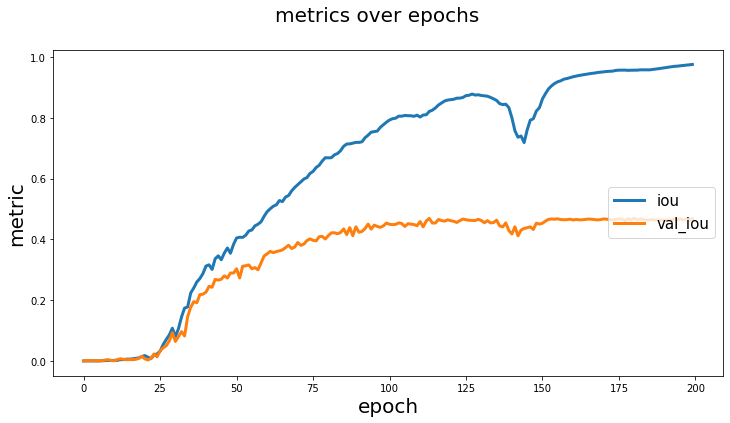

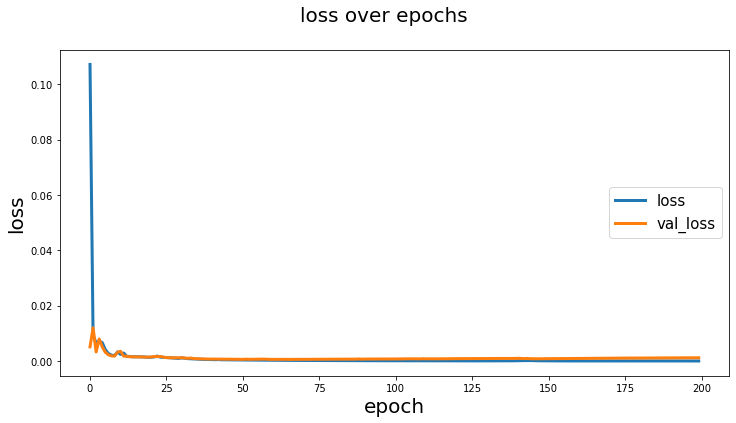

In [21]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [22]:
y_pred = model.predict(X_test)

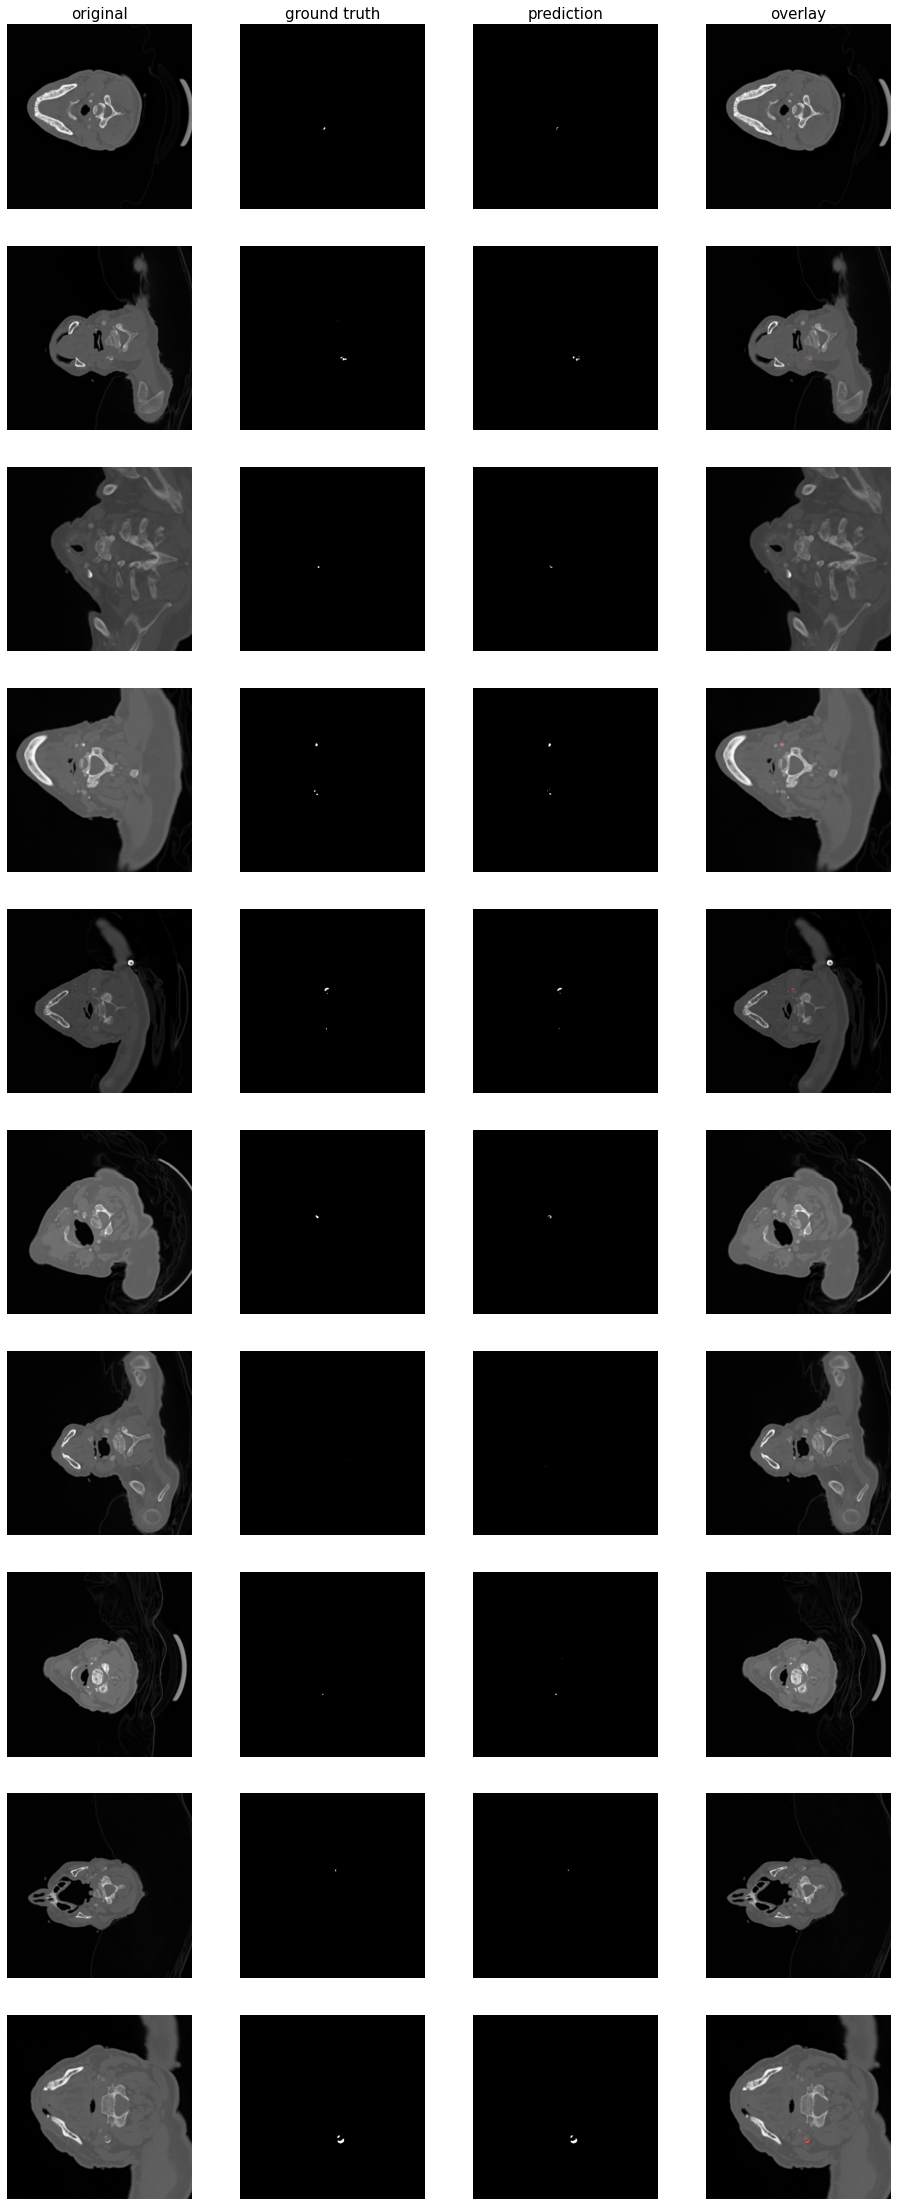

In [23]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [24]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 355ms/step - loss: 8.7113e-04 - iou: 0.4698 - iou_thresholded: 0.4812
